# Classificação de Imagens usando Deep Neural Network: aplicação

Quando você terminar esta tarefa você terá encerrado a útlima tarefa deste módulo. 

Você irá utilizar as funções que você implementou na tarefa anterior para construir uma rede neural profunda, e aplicar esta rede na classificação gato vs não-gato. Esperamos que exista uma melhora na precisão desta rede quando comparada com a implementação utilizando regressão logística.  

**Após esta tarefa você será capaz de:**
- Construir e aplicar redes neurais profundas em aprendizado supervisionado.  

Vamos começar!

## 1 - Pacotes

Vamos primeiro importar todos os pacotes que serão utilizados durante esta tarefa.  
- [numpy](www.numpy.org) é o pacote para computação científica do Python. 
- [matplotlib](http://matplotlib.org) é a biblioteca para plotar gráficos do Python.
- [h5py](http://www.h5py.org) é um pacote comum para interagir com uma base de dados armazenada em um arquivo H5.
- [PIL](http://www.pythonware.com/products/pil/) e [scipy](https://www.scipy.org/) são usadas para testar o modelo com uma imagem qualquer.
- dnn_app_utils possui as funções implementadas na tarefa anterior. 
- np.random.seed(1) é utilizada para criar chamadas consistentes. Não altere a semente.  

In [2]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v2 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # ajusta valores default para plotagem de imagens
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2 - Base de dados

Vamos utilizar a mesma base de dados "Gato vs não-Gato" utilizada no exemplo implementado com regressão logística. Aquele modelo, você deve se lembrar, possui uma precisão de 70% para a classificação utilizando o conjunto de teste. Esperamos que este novo modelo tenha um desempenho melhor! 

**Problema**: dada uma base de dados ("data.h5") contendo:
    - um conjunto de treinamento contendo m_train imagens classificadas como gato (1) ou não-gato (0)
    - um conjunto de teste com m_test imagens classificadas como gato ou não-gato.
    - cada imagem está no formato (num_px, num_px, 3) onde 3 é o número de canais (RGB).

Vamos nos familiarizar com esta base de dados. Execute a célula abaixo para carregar a base de dados.

In [3]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

O código abaixo irá apresentar uma das imagens da base de dados. Sinta-se a vontade para alterar o valor do index e ver outras imagens. 

y = 1. É uma imagem de cat.


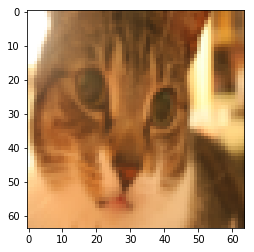

In [5]:
# Exemplo de imagem
index = 200
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". É uma imagem de " + classes[train_y[0,index]].decode("utf-8") +  ".")

In [6]:
# Explore sua base de dados 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Numero de exemplos de treinamento: " + str(m_train))
print ("Numero de exemplos de teste: " + str(m_test))
print ("Tamanho de cada imagem: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("Formato do train_x_orig: " + str(train_x_orig.shape))
print ("Formato do train_y: " + str(train_y.shape))
print ("Formato do test_x_orig: " + str(test_x_orig.shape))
print ("Formato do test_y: " + str(test_y.shape))

Numero de exemplos de treinamento: 209
Numero de exemplos de teste: 50
Tamanho de cada imagem: (64, 64, 3)
Formato do train_x_orig: (209, 64, 64, 3)
Formato do train_y: (1, 209)
Formato do test_x_orig: (50, 64, 64, 3)
Formato do test_y: (1, 50)


Como sempre, reformatamos e normalizamos as imagens antes de utilizá-las na rede neural. O código é dado na célula abaixo. 

<img src="images/imvectorkiank.png" style="width:450px;height:300px;">

<caption><center> <u>Figura 1</u>: Conversão de imagem para vetor. <br> </center></caption>

In [7]:
# Reformate os exemplos de treinamento e de teste 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # O "-1" faz com que as demais dimensões fiquem achatadas.
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Normaliza os dados para ter os valores das características entre 0 e 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("Formato do train_x: " + str(train_x.shape))
print ("Formato do test_x: " + str(test_x.shape))


Formato do train_x: (12288, 209)
Formato do test_x: (12288, 50)


$12,288$ é igual a $64 \times 64 \times 3$ que é o tamanho de um vetor reformatado da imagem.

## 3 - Arquitetura do modelo

Agora que você já está familiarizado com a base de dados, está na hora de construir uma rede neural profunda para classificar imagens como gatos ou não-gatos. 

Iremos construir dois modelos diferentes:
- Uma rede neural com duas camadas escondidas.
- Uma rede neural com L camadas escondidas.

Será possível então comparar o desempenho destes dois modelos tentando valores diferentes para $L$.  

Vamos dar uma olhada nas duas arquiteturas.

### 3.1 - Rede Neural de 2 camadas

<img src="images/2layerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figura 2</u>: Rede Neural com 2 camadas escondidas. <br> O modelo pode ser resumido como:***INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT***. </center></caption>

<u>Arquitetura detalhada da Figura 2</u>:
- O tamanho da imagem de entrada é (64,64,3) que é transformada em um vetor de tamanho $(12288,1)$. 
- O vetor correspondente: $[x_0,x_1,...,x_{12287}]^T$ é multiplicado pelo peso da matriz $W^{[1]}$ de tamanho $(n^{[1]}, 12288)$.
- Adiciona-se um termo de bias e determina-se o valor da ReLu para obter o seguinte vetor: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- Repete-se o mesmo processo.
- Multiplica-se o vetor resultante por $W^{[2]}$ e adiciona-se a sua interceptação (bias). 
- Finalmente, determina-se a sigmoid do resultado. Se for maior que 0.5, classifica-se como um gato.

### 3.2 - Rede Neural Profunda com L camadas

É difícil representar um rede neural profunda com L camadas da forma mostrada acima. De qualquer forma, segue uma rede simplificada:

<img src="images/LlayerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figura 3</u>: Rede Neural com L camadas escondidas. <br> O modelo pode ser resumido como: ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID***</center></caption>

<u>Detalhes da arquitetura da figura 3</u>:
- A imagem de entrada possui formato (64,64,3) transformada em vetor do tamanho (12288,1).
- O vetor: $[x_0,x_1,...,x_{12287}]^T$ é multiplicado pelo peso da matriz $W^{[1]}$ e se adiciona a interceptação $b^{[1]}$. O resultado é chamado de unidade linear.
- Em seguida determina-se o valor do ReLu da unidade linear. Este processo pode ser repetido diversas vezes para cada $(W^{[l]}, b^{[l]})$ dependendo da arquitetura do modelo.
- Finalmente, determina-se a sigmoid do resultado. Se for maior que 0.5, classifica-se como um gato.

### 3.3 - Metodologia Geral

Como sempre iremos seguir a metodologia de deep learning para construir o modelo:
    1. Inicialize os parâmetros / Defina os hyperparâmetros
    2. Repita por num_iterations:
        a. Propagação para frente
        b. Compute função custo
        c. Propagação para trás
        d. Atualização dos parâmetros (usando parâmetros, e grads da propagação para trás) 
    4. Use os parâmetros treinados para fazer a previsão de novos dados

Vamos então implementar estes dois modelos!

## 4 - Rede Neural de 2 camadas

**Exercício**:  Utilize as funções auxiliares que você implementou na tarefa anterior para construir uma rede neural com 2 camadas escondidas com a seguinte estrutura: *LINEAR -> RELU -> LINEAR -> SIGMOID*. As funções que você deve precisar e seus argumentos são: 
```python
def inicializar_parametros(n_x, n_h, n_y):
    ...
    return parameters 
def para_frente_linear_ativacao(A_prev, W, b, activation):
    ...
    return A, cache
def compute_custo(AL, Y):
    ...
    return cost
def para_tras_linear_ativacao(dA, cache, activation):
    ...
    return dA_prev, dW, db
def atualize_parametros(parameters, grads, learning_rate):
    ...
    return parameters
```

In [40]:
### CONSTANTES QUE DEFINEM O MODELO ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

Execute a célula abaixo para treinar seus parâmetros. Veja se o modelo roda. O custo deve estar decrescendo. Leva em torno de 2 minutos para executar 2500 interações. Verifique que o custo após a interação 0 bate com o esperado, se não bater clique no botão (⬛) na barra de controle do notebook para interromper a execução e tene encontrar o erro. 

In [49]:
# FUNÇÃO DE AVALIAÇÃO: two_layer_model

def modelo_2_camadas(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implementa uma rede neural com 2 camadas escondidas: LINEAR->RELU->LINEAR->SIGMOID.
    
    Argumentos:
    X -- dados de entrada no formato (n_x, numero de exemplos)
    Y -- vetor de classificação correta (contendo 1 se gato, 0 se não-gato), no formato (1, numero de exemplos)
    layers_dims -- tamanho de cada camada (n_x, n_h, n_y)
    num_iterations -- numero de interações no loop de otimizacao
    learning_rate -- taxa de aprendizadao da regra de atualizacao do gradiente descendente
    print_cost -- se for True, imprime o custo a cada 100 interações 
    
    Retorna:
    parametros -- um dicionário contendo W1, W2, b1, e b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # para armazenar os valores do custo
    m = X.shape[1]                           # numero de exemplos
    (n_x, n_h, n_y) = layers_dims
    
    # Inicializa o dicionário de parâmetros chamando uma das funções previamente implementadas
    ### INICIE O SEU CÓDIGO AQUI ### (≈ 1 linha de código)
    parametros = inicializa_parametros(n_x, n_h, n_y)
    ### TÉRMINO DO CÓDIGO ###
    
    # Obtenha W1, b1, W2 e b2 do dicionário de parâmetros.
    W1 = parametros["W1"]
    b1 = parametros["b1"]
    W2 = parametros["W2"]
    b2 = parametros["b2"]
    
    # Loop (gradiente descendente)

    for i in range(0, num_iterations):

        # Propagação para frente: LINEAR -> RELU -> LINEAR -> SIGMOID. Entrads: "X, W1, b1". Saídas: "A1, cache1, A2, cache2".
        ### INICIE O SEU CÓDIGO AQUI ### (≈ 2 linhas de código)
        A1, cache1 = para_frente_linear_ativacao(X, W1, b1, activation = "relu")
        A2, cache2 = para_frente_linear_ativacao(A1, W2, b2, activation = "sigmoid")
        ### TÉRMINO DO CÓDIGO ###
        
        # Compute custo
        ### INICIE O SEU CÓDIGO AQUI ### (≈ 1 linha de código)
        cost = compute_custo(A2, Y)
        ### TÉRMINO DO CÓDIGO ###
        
        # Inicializar a propagacao para tras
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Propagacao para tras. Entradas: "dA2, cache2, cache1". Saídas: "dA1, dW2, db2; e dA0 (nao usado), dW1, db1".
        ### INICIE O SEU CÓDIGO AQUI ### (≈ 2 linhas de código)
        dA1, dW2, db2 =  para_tras_linear_ativacao(dA2, cache2, activation = "relu" )
        dA0, dW1, db1 = para_tras_linear_ativacao(dA1, cache1, activation = "sigmoid")
        ### TÉRMINO DO CÓDIGO ###
        
        # Ajuste dos grads['dWl'] para dW1, grads['db1'] para db1, grads['dW2'] para dW2, grads['db2'] para db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Atualiza os parametros.
        ### INICIE O SEU CÓDIGO AQUI ### (aprox. 1 linha de codigo)
        parametros = atualiza_parametros(parametros, grads, learning_rate)
        ### TÉRMINO DO CÓDIGO ###

        # Obtem W1, b1, W2, b2 dos parametros
        W1 = parametros["W1"]
        b1 = parametros["b1"]
        W2 = parametros["W2"]
        b2 = parametros["b2"]
        
        # Imprime o custo a cada 100 exemplos de treinamento
        if print_cost and i % 100 == 0:
            print("Custo após interação {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plota o custo

    plt.plot(np.squeeze(costs))
    plt.ylabel('custo')
    plt.xlabel('iteracoes (x 10)')
    plt.title("Taxa de aprendizado =" + str(learning_rate))
    plt.show()
    
    return parametros

Custo após interação 0: 0.6930497356599888
Custo após interação 100: 0.6928450446466331
Custo após interação 200: 0.6928450446466331
Custo após interação 300: 0.6928450446466331
Custo após interação 400: 0.6928450446466331
Custo após interação 500: 0.6928450446466331
Custo após interação 600: 0.6928450779090483
Custo após interação 700: 0.6928731976891992
Custo após interação 800: 0.6929832910026712
Custo após interação 900: 0.6849791489223931
Custo após interação 1000: 0.6648779904781795
Custo após interação 1100: 0.6525944680490656
Custo após interação 1200: 0.6471398661254981
Custo após interação 1300: 0.6438587916929092
Custo após interação 1400: 0.6406032365371824
Custo após interação 1500: 0.6364060614171106
Custo após interação 1600: 0.6292006951072757
Custo após interação 1700: 0.6222385069602767
Custo após interação 1800: 0.6153960645156566
Custo após interação 1900: 0.6098786841225582
Custo após interação 2000: 0.6052205725539127
Custo após interação 2100: 0.6018729481942657


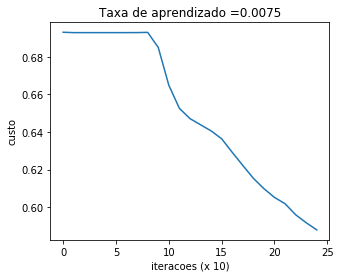

In [50]:
parametros = modelo_2_camadas(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

**Saída Esperada**:
<table> 
    <tr>
        <td> **Custo após a interação  0**</td>
        <td> 0.6930497356599888 </td>
    </tr>
    <tr>
        <td> **Custo após a interação 100**</td>
        <td> 0.6464320953428849 </td>
    </tr>
    <tr>
        <td> **...**</td>
        <td> ... </td>
    </tr>
    <tr>
        <td> **Custo após a interação 2400**</td>
        <td> 0.048554785628770206 </td>
    </tr>
</table>

Ainda bem que foi utilizada vetorização na implementação, de outra forma o tempo de excução poderia ser até 10 vezes maior para treinar a rede. 

Agora é possível utilizar os parâmetros treinados para classificar imagens da base de daos. Para ver as previsões no conjunto de treinamento e no conjunto de teste execute a célula abaixo.

In [52]:
predictions_train = prever(train_x, train_y, parametros)

Accuracy: 0.8851674641148324


**Saída esperada**:
<table> 
    <tr>
        <td> **Accuracy**</td>
        <td> 1.0 </td>
    </tr>
</table>

In [53]:
predictions_test = prever(test_x, test_y, parametros)

Accuracy: 0.56


**Saída esperada**:

<table> 
    <tr>
        <td> **Accuracy**</td>
        <td> 0.72 </td>
    </tr>
</table>

**Nota**: Pode-se notar que rodando o modelo com menos interações (algo em torno de 1500) da uma precisao melhor no conjunto de teste. Isto é chamado de "parada cedo" e iremos falar sobre isto mais a frente. A parada cedo é uma forma de se evitar o sobreajuste.  

Parabéns! A sua rede de duas camadas tem um desempenho melhor (72%) que a sua rede de regressão logística (70%) - (mesmo??). Vamos ver o que acontece quando utilizamos um modelo com $L$ camadas. 

## 5 - Rede Neural com L camadas

**Exercício**: Utilize as funções auxiliares que foram implementadas na tarefa passada para construir uma rede neural com $L$ camadas escondidas, seguindo a estrutura:  *[LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID*. As funções que você deve precisar são:
```python
def inicializa_parametros_deep(layer_dims):
    ...
    return parameters 
def modelo_para_frente_L(X, parameters):
    ...
    return AL, caches
def compute_custo(AL, Y):
    ...
    return cost
def modelo_para_tras_L(AL, Y, caches):
    ...
    return grads
def atualize_parametros(parameters, grads, learning_rate):
    ...
    return parameters
```

In [60]:
### CONSTANTES ###
layers_dims = [12288, 20, 7, 5, 1] #  modelo com 5 camadas

In [73]:
# FUNÇÃO DE AVALIAÇÃO: modelo_L_camadas

def modelo_L_camadas(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implementa uma rede neural com L camadas escondidas: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Argumentos:
    X -- dados de entrada, um array numpy no formato (numero de exemplos, num_px * num_px * 3)
    Y -- classificacao correta dos dados de entrada, um vetor (contem 1=gato, 0=nao-gato), no formato (1, numero de exemplos)
    layers_dims -- lista contendo o tmanho da entrada e o tamanho de cada camada, de comprimento (numero de camadas + 1).
    learning_rate -- a taxa de aprendizado para a regra de atualizacao do gradiente descendente
    num_iterations -- numero de interacoes do loop de otimizacao
    print_cost -- se True, imprime o custo a cada 100 interacoes
    
    Retorna:
    parametros -- parametros aprendidos pelo modelo. Eles podem ser utilizados na previsao de novas saidas.
    """

    np.random.seed(1)
    costs = []                         # usado para manter os valores de custo
    
    # Parametros de inicializacao.
    ### INICIE O SEU CÓDIGO AQUI ###
    parametros = inicializa_parametros_deep(layers_dims)
    ### TÉRMINO DO CÓDIGO ###
    
    # Loop (gradiente descendente)
    for i in range(0, num_iterations):

        # Propagacao para frente: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### INICIE O SEU CÓDIGO AQUI ### (≈ 1 linha de codigo)
        AL, caches = modelo_para_frente_L(X, parametros)
        ### TÉRMINO DO CÓDIGO ###
        
        # Compute custo.
        ### INICIE O SEU CÓDIGO AQUI ### (≈ 1 linha de codigo)
        cost = compute_custo(AL, Y)
        ### TÉRMINO DO CÓDIGO ###
    
        # propagacao para tras.
        ### INICIE O SEU CÓDIGO AQUI ### (≈ 1 linha de codigo)
        grads = modelo_para_tras_L(AL, Y, caches)
        ### TÉRMINO DO CÓDIGO ###
 
        # Atualiza parametros.
        ### INICIE O SEU CÓDIGO AQUI ### (≈ 1 linha de codigo)
        parametros = atualiza_parametros(parametros, grads, learning_rate)
        ### TÉRMINO DO CÓDIGO ###
                
        # Imprime o custo a cada 100 interacoes
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('custo')
    plt.xlabel('interacoes (* 10)')
    plt.title("Taxa de aprendizado =" + str(learning_rate))
    plt.show()
    
    return parametros

Em seguida iremos treinar o modelo de rede neural com 5 camadas escondidas. 

Execute a célula abaixo para treinar o modelo. O custo deve decrescer em cada interação. Isto deve levar algo em torno de 2 a 3 minutos para as 2500 interações. Verifique o custo após a interação 0 se o valor é igual ao esperado, caso não seja, ckique no botão (⬛) na barra superior do notebook para interromper a execução e verifique onde está o erro. 

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225
Cost after iteration 2000: 0.113821
Cost after iteration 2100: 0.107839
Cost after iteration 2200: 0.102855
Cost after iteration 2300: 0.100897
Cost after iteration 2400: 0.092878


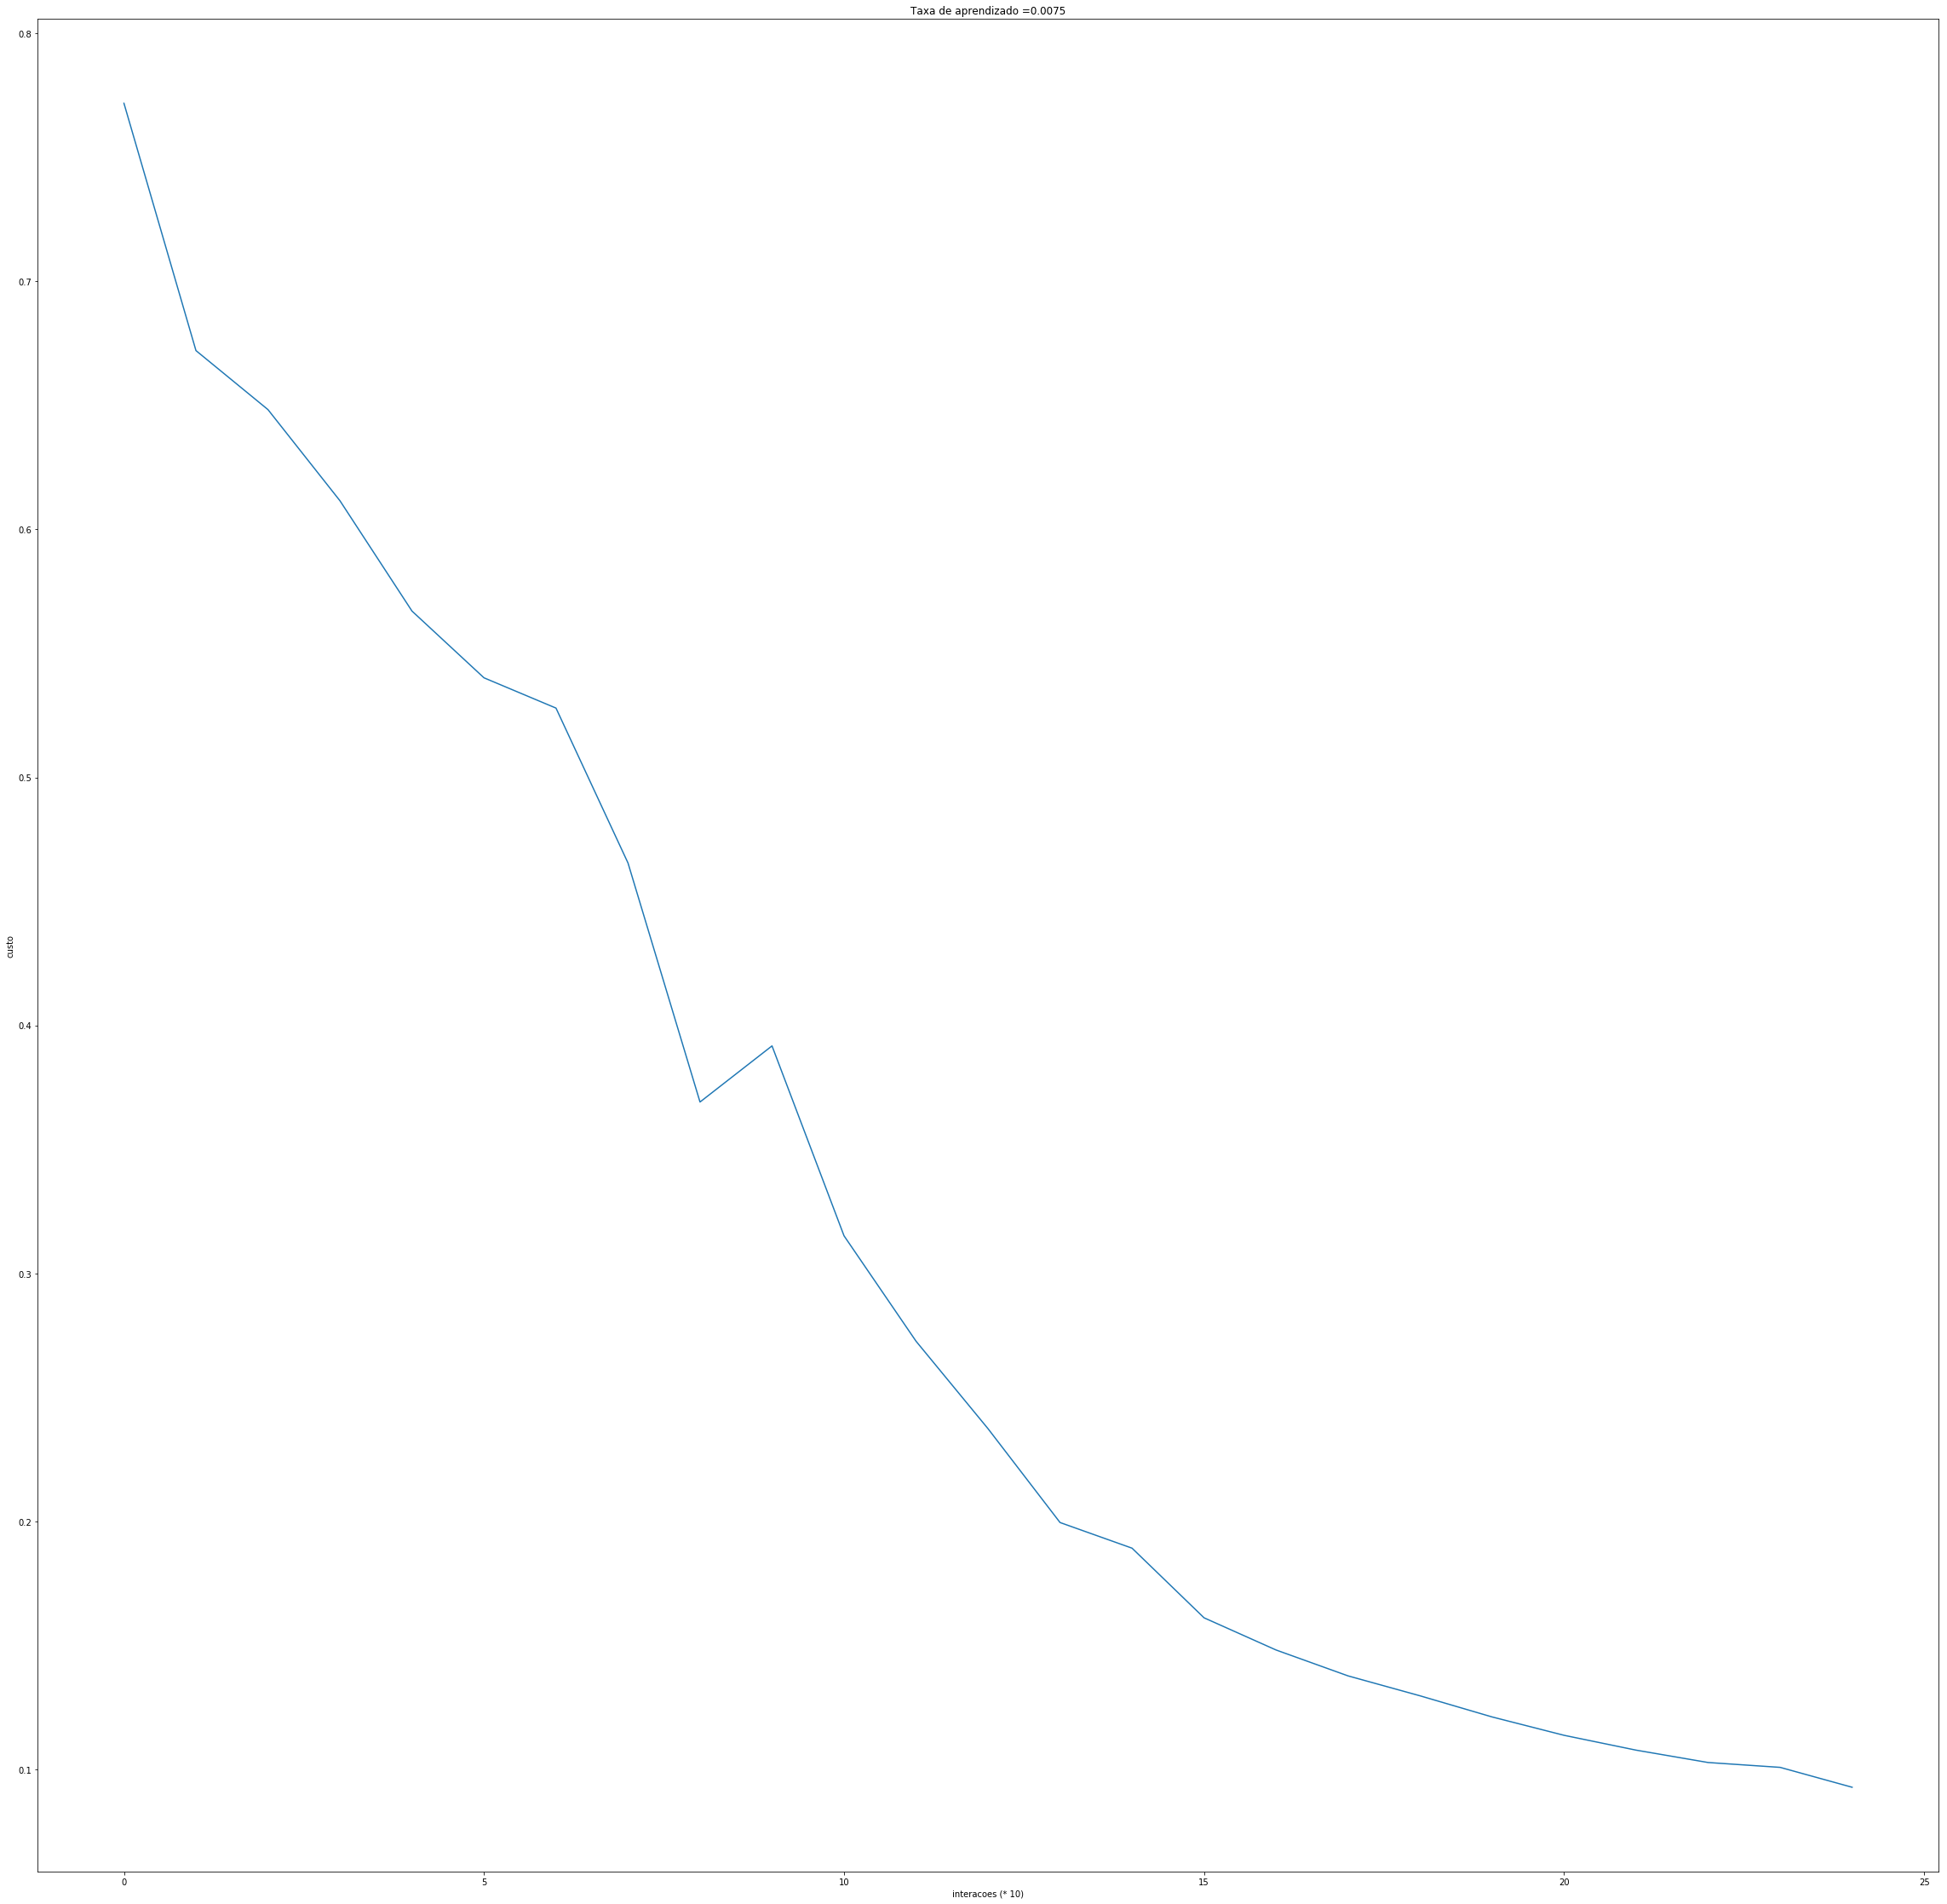

In [74]:
parameters = modelo_L_camadas(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

**Saída Esperada**:
<table> 
    <tr>
        <td> **Custo após interacao 0**</td>
        <td> 0.771749 </td>
    </tr>
    <tr>
        <td> **Custo após interacao 100**</td>
        <td> 0.672053 </td>
    </tr>
    <tr>
        <td> **...**</td>
        <td> ... </td>
    </tr>
    <tr>
        <td> **Custo após interacao 2400**</td>
        <td> 0.092878 </td>
    </tr>
</table>

In [75]:
pred_train = prever(train_x, train_y, parameters)

Accuracy: 0.9856459330143539


<table>
    <tr>
    <td>
    **Precisao Treinamento**
    </td>
    <td>
    0.985645933014
    </td>
    </tr>
</table>

In [76]:
pred_test = prever(test_x, test_y, parameters)

Accuracy: 0.8


**Saída Esperada**:

<table> 
    <tr>
        <td> **Precisao no Teste**</td>
        <td> 0.8 </td>
    </tr>
</table>

Parabéns! Parece que a sua rede neural de 5 camadas tem um desempenho melhor (80%) do que a sua rede neural de 2 camadas (72%) na mesma base de dados. 

Este é considerado um bom desempenho para este tipo de tarefa. Bom trabalho! 

No próximo modulo veremos como melhorar o desempenho de uma rede neural profunda, você verá como obter precisões ainda maiores ajustando os hyperparametros sistematicamente (learning_rate, layers_dims, num_iterations, e outros que serão apresentados no proximo modulo). 

##  6) Analise de resultados

Primeiro vamos ver algumas imagens onde a rede de L camadas classificou a imagem erradamente. Isto irá mostrar algumas imagens classificadas incorretamente. 

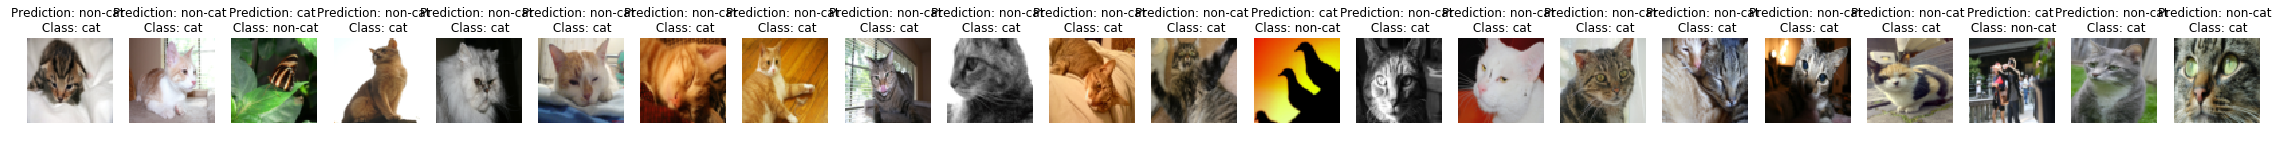

In [65]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

**Alguns tipos de imagens onde o modelo tende a errar inclui:** 
- Corpo do gato em uma posição não usual.
- O gato aparece contra um background de cor similar.
- Cor de gato incomum ou especie incomum.
- Ângulo da camera.
- Brilho da imagem
- Variação da escala (gato é muito pequeno ou muito grande na imagem) 

## 7) Teste com sua própria imagem (opcional) ##

Parabéns, você concluiu esta tarefa. Agora você pode utilizar a sua própria imagem e ver a saída do modelo. Execute os seguintes passos:
    1. Clique em "File" na barra superior deste notebook, e clique em "Open" para ir para o diretório da tarefa.
    2. Adicione a sua imagem para o diretório do notebook, no diretório "images".
    3. Modifique o nome da imagem no código abaixo.
    4. Execute o código e veja se o algoritmo acertou a classificação (1 = gato, 0 = não-gato)!

C:\Users\anara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  import sys
C:\Users\anara\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


Accuracy: 1.0
y = 0.0, seu modelo de L camadas indica que a imagem é um "non-cat" picture.


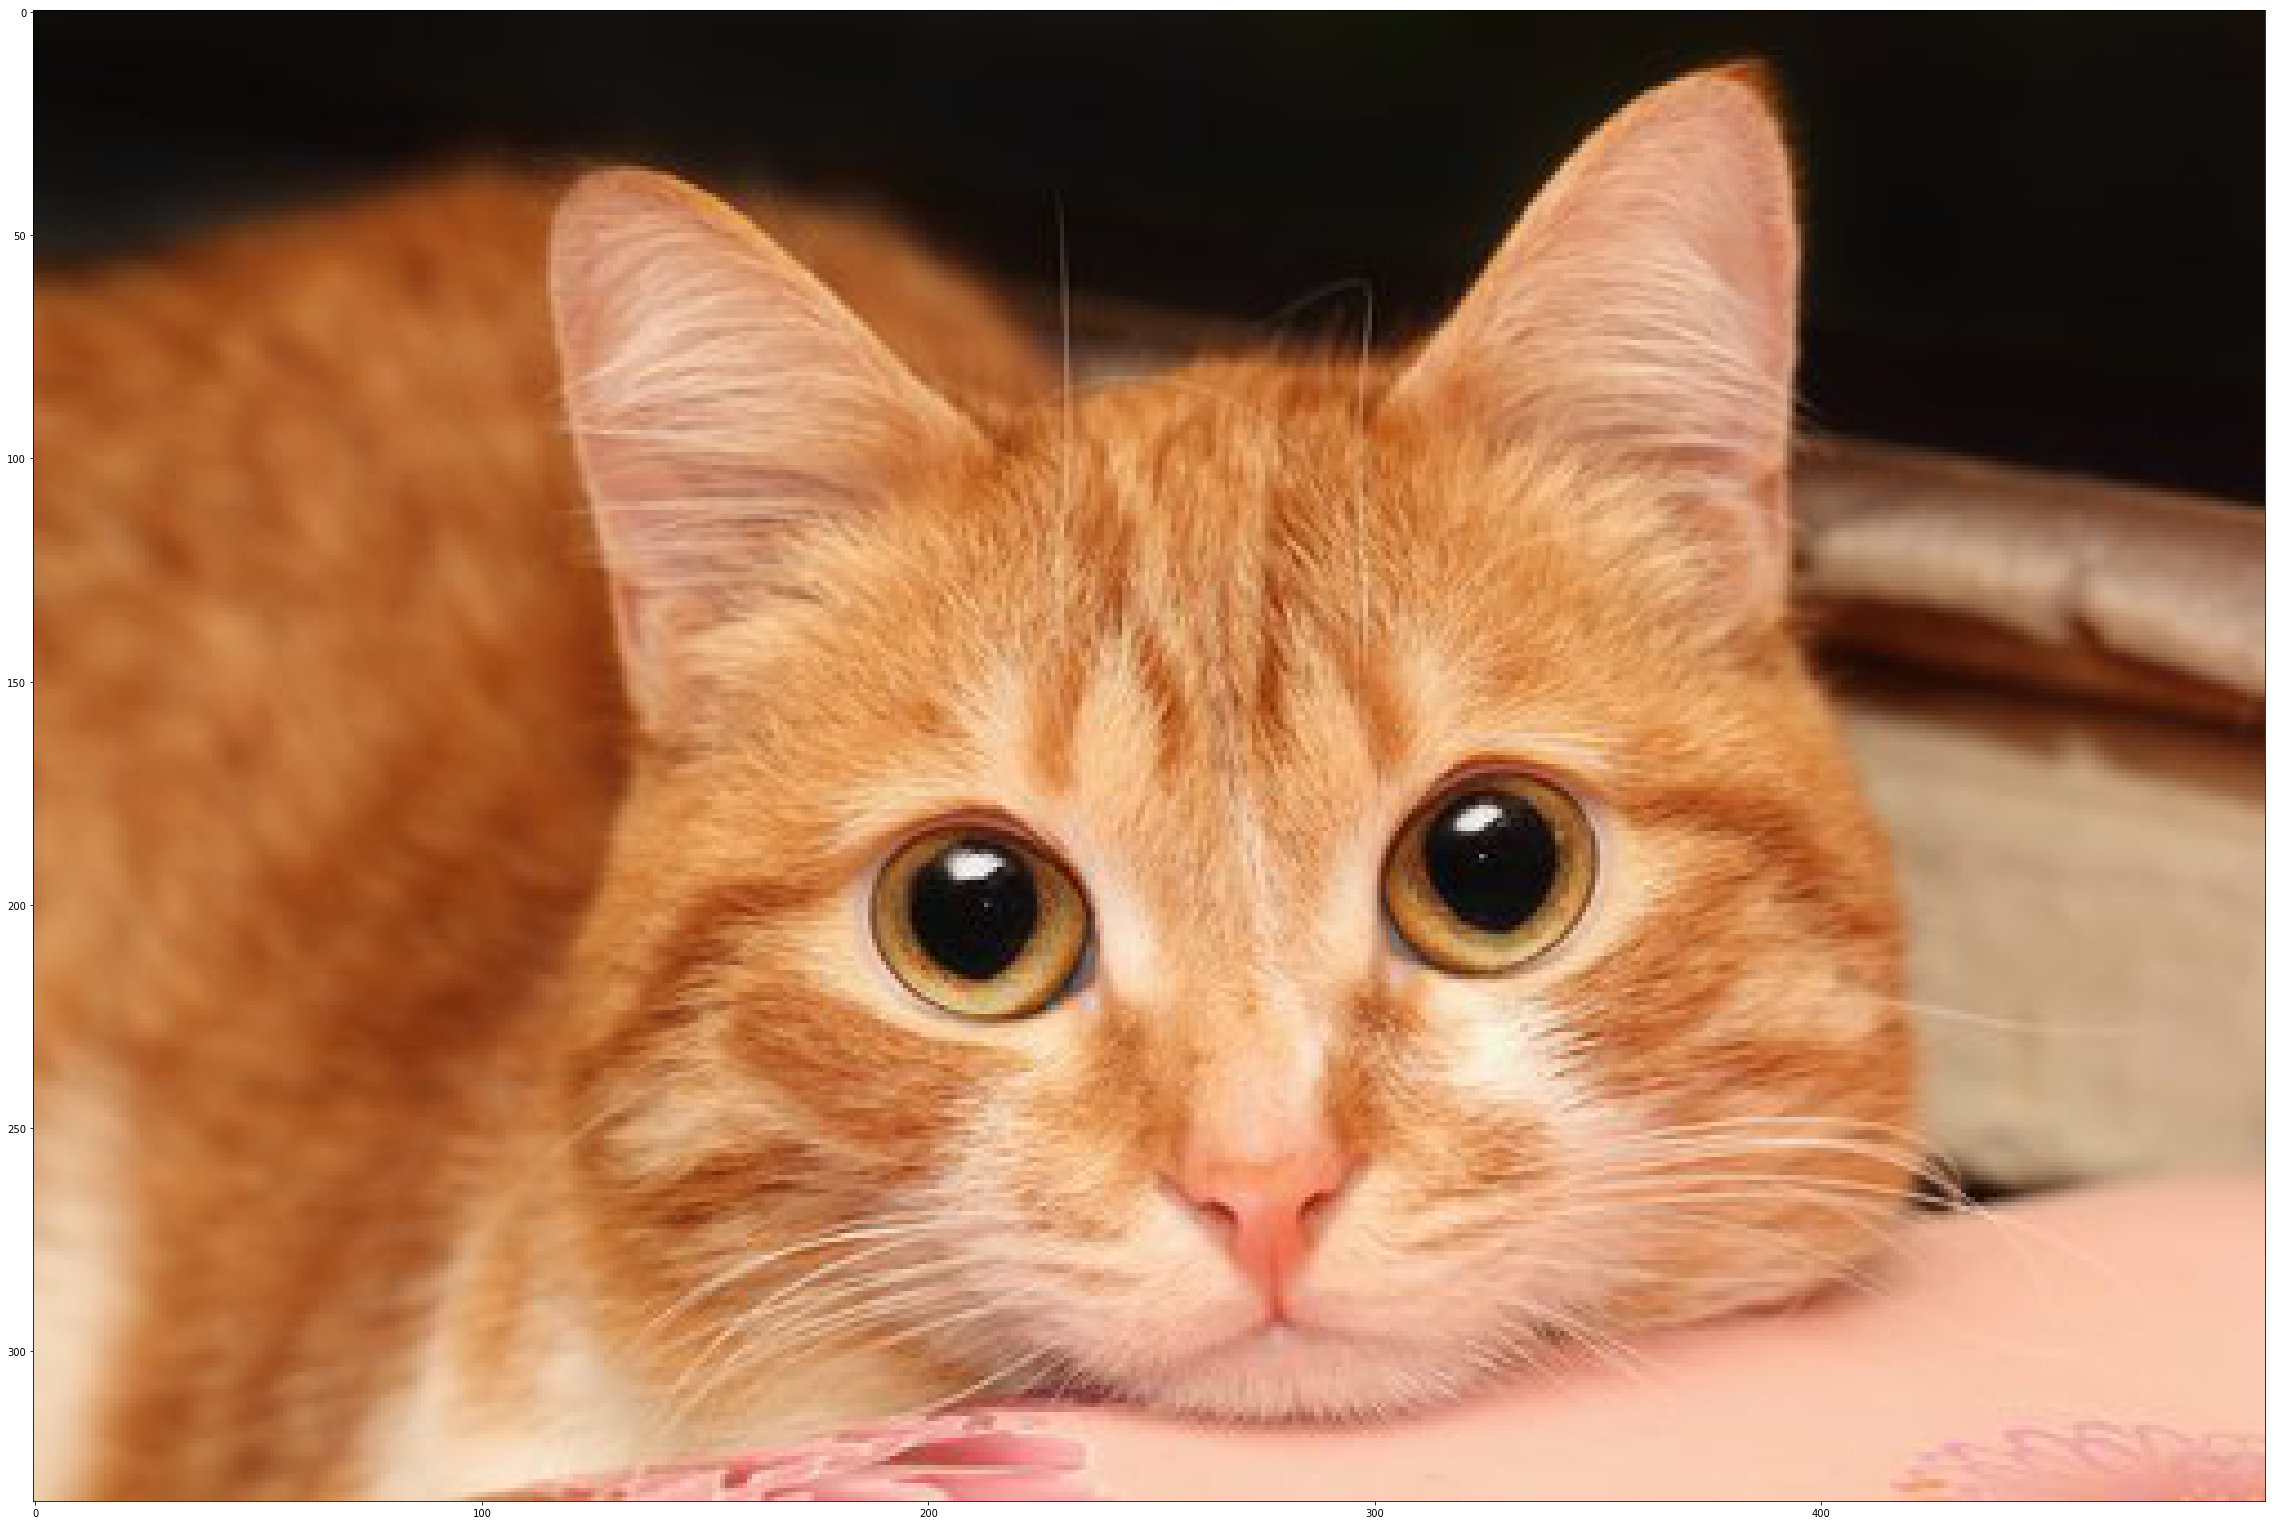

In [68]:
## INICIE O SEU CÓDIGO AQUI ##
my_image = "meu_gato.jpg" # troque aqui o nome do arquivo 
my_label_y = [0] # indique aqui a classe real da sua imagem (1 -> gato, 0 -> nao-gato)
## TÉRMINO DO CÓDIGO ##

fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((num_px*num_px*3,1))
my_predicted_image = prever(my_image, my_label_y, parameters)

plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", seu modelo de L camadas indica que a imagem é um \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

**Referencias**:

- Para recarregar o módulo externo: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython